In [1]:
#Importamos librerias utiles
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Programar el algoritmo de retropropagacion

usando NumPy para una tarea de clasificación binaria presuponiendo una red densa con dos capas ocultas y la funcion de perdida de entropia cruzada binaria, entrena y evalua la red en algun conjunto de datos

In [2]:
#definimos la funcion de perdida entropia cruzada binaria
def EntropiaBinaria(y, p):
    p[p==0] = np.nextafter(0., 1.)
    p[p==1] = np.nextafter(1., 0.)
    return -(np.log(p[y==1]).sum() + np.log(1-p[y==0]).sum())

In [3]:
#Dado que se trata de clasificacion binaria y a todos nos gustan las funciones continuas y derivables
#para todo R, entonces usaremos la funcion de activacion sigmoide para todas las capas ocultas
def sigmoid(z):
    return 1/(1+np.exp(-z))
#definimos la derivada de la funcion sigmoide
def sigmoidDerivative(w):
    return np.multiply(sigmoid(w),(1-sigmoid(w)))

In [4]:
#Definimos nuestra metrica de exactitud
def exactitud(y, prediccion):
    return (y==prediccion).mean()*100

Dado que estamos restringidos a dos capas de ocultas, una de salida y una de entrada, nuestras ecuaciones de pesos y activaciones (propagacion hacia adelante) viene dado por:
$$\vec{a}^{(1)} = \vec{x}^{(i)}$$
$$\vec{z}^{(2)} = W^{(1)T} \cdot \vec{a}^{(1)} + \vec{b}^{(1)}$$
$$\vec{a}^{(2)} = \phi (\vec{z}^{(2)})$$
$$\vec{z}^{(3)} = W^{(2)T} \cdot \vec{a}^{(2)} + \vec{b}^{(2)}$$
$$\vec{a}^{(3)} = \phi (\vec{z}^{(3)})$$
$$\vec{z}^{(4)} = W^{(3)T} \cdot \vec{a}^{(3)} + \vec{b}^{(3)}$$
$$\vec{a}^{(4)} = \phi (\vec{z}^{(4)})$$
$$\hat{y}^{(i)} = a^{(4)}$$

Es decir tenemos tres matrices de pesos $W^{1,2,3}$ y tres vectores de sesgos $b^{1,2,3}$ una para cada capa respectivamente

In [5]:
#definimos la funcion de propagacion hacia adelante
def propagacion(x, w1, b1, w2, b2, w3, b3):
    #calculamos z2:
    z2 = (w1.T @ x[:,np.newaxis]) + b1
    #calculamos a2
    a2 = sigmoid(z2)
    #calculamos z3
    z3 = (w2.T @ a2) + b2
    #calculamos a3
    a3 = sigmoid(z3)
    #calculamos z4
    z4 = (w3.T @ a3) + b3
    #hacemos la prediccion (obtenemos a4)
    prediccion = sigmoid(z4)
    #regresamos los valores que acabamos de calcular
    return z2, a2, z3, a3, z4, prediccion

Nuevamente para entrenar hay que calcular el error de la funcion de perdida (costo) esto se hace por el descenso del gradiente, las reglas de actualizacion del mismo definidas en la libreta de teoria y el algoritmo de retropropagacion

In [6]:
#definimos nuestro algoritmo de retropropagacion
def retropropagacion(x, y, learningRate, epochs, neuronasOcultas):
    ejemplos = x.shape[0]
    entradas = x.shape[1]
    #inicializamos los pesos W y b de forma aleatoria
    W1 = np.sqrt(1.0 / entradas) * np.random.randn(entradas, neuronasOcultas)
    b1 = np.zeros((neuronasOcultas, 1))
    W2 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b2 = np.zeros((neuronasOcultas, 1))
    W3 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b3 = np.zeros((1, 1))
    #definimos el vector de perdidas, que en cada epoca se va a actualizar
    perdidas = np.zeros((epochs))
    #definimos el vector de exactitudes que en cada epoca se ca a actualizar
    exactitudes = np.zeros((epochs))
    #definimos el vector de predicciones que corresponde al numero de salidas
    predicciones = np.zeros((y.shape))
    #iteramos sobre las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos de entrenamiento
        for ejemplo in range(ejemplos):
            #calculamos los vectores resultantes de la propagacion
            z2, a2, z3, a3, z4, prediccion = propagacion(x[ejemplo], W1, b1, W2, b2, W3, b3)
            #algoritmo de retropropagacion:
            #3) calcula el error de la capa de salida (punto 3 del notebook de teoria)
            # gradiente de C en la direccion de a producto de haramad
            #con la derivada de la funcion de activacion evaluada en z^{L}
            gradUltimaCapa = np.multiply((prediccion - y[ejemplo]), sigmoidDerivative(z4))
            #actualiza los pesos de la ultima capa usando descenso del gradiente
            W3 = W3 - learningRate * np.outer(a3, gradUltimaCapa)
            b3 = b3 - learningRate * gradUltimaCapa
            #4.1) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 3
            gradCapa3 = np.multiply((W3 @ gradUltimaCapa), sigmoidDerivative(z3))
            #actualiza los pesos de la capa 3 usando descenso del gradiente
            W2 = W2 - learningRate * np.outer(a2, gradCapa3)
            b2 = b2 - learningRate * gradCapa3
            # 4.2) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 2
            gradCapa2 = np.multiply((W2 @ gradCapa3), sigmoidDerivative(z2))
            #actualiza los pesos de la capa 2 usando descenso del gradiente
            W1 = W1 - learningRate * np.outer(x[ejemplo], gradCapa2)
            b1 = b1 - learningRate * gradCapa2
            ##Fin de la retropropagacion
            #asignamos nuestra prediccion
            predicciones[ejemplo] = prediccion
        #calculamos la perdida para la epoca actual
        perdidas[epoch] = EntropiaBinaria(y, predicciones)
        #calculamos las exactitudes para la epoca actual
        exactitudes[epoch] = exactitud(y, np.round(predicciones))
        #imprimimos la perdida y la exactitud para la epoca actual
        print('Epoch {0}: Perdida = {1} Exactitud = {2}'.format(epoch,perdidas[epoch],exactitudes[epoch]))
    return W1, W2, W3, b1, b2, b3, perdidas, exactitudes

Entrenemos nuestra red con el mismo XNOR de la libreta pasada

In [7]:
#definimos las entradas
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
#definimos las salidas
y = np.array([[1, 0, 0, 1]]).T
#Para reproducibilidad ponemos una semilla
np.random.seed(0)
#entrenamos la red
W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacion(x,y,epochs=1500,learningRate=0.5,neuronasOcultas=7)

Epoch 0: Perdida = 2.9745368360323496 Exactitud = 50.0
Epoch 1: Perdida = 2.964349329100816 Exactitud = 25.0
Epoch 2: Perdida = 2.9590023856373056 Exactitud = 25.0
Epoch 3: Perdida = 2.9562696962013395 Exactitud = 25.0
Epoch 4: Perdida = 2.9549423709022387 Exactitud = 25.0
Epoch 5: Perdida = 2.9543708214344986 Exactitud = 25.0
Epoch 6: Perdida = 2.9542074916798895 Exactitud = 25.0
Epoch 7: Perdida = 2.954266518446815 Exactitud = 25.0
Epoch 8: Perdida = 2.9544482882437277 Exactitud = 25.0
Epoch 9: Perdida = 2.9546991695371676 Exactitud = 25.0
Epoch 10: Perdida = 2.9549900855692712 Exactitud = 25.0
Epoch 11: Perdida = 2.955305119344557 Exactitud = 50.0
Epoch 12: Perdida = 2.955635446608479 Exactitud = 50.0
Epoch 13: Perdida = 2.955976096660244 Exactitud = 50.0
Epoch 14: Perdida = 2.956324215203102 Exactitud = 50.0
Epoch 15: Perdida = 2.9566781266621387 Exactitud = 50.0
Epoch 16: Perdida = 2.957036823497653 Exactitud = 50.0
Epoch 17: Perdida = 2.957399684755449 Exactitud = 50.0
Epoch 18: 

Epoch 356: Perdida = 3.1722063174147452 Exactitud = 50.0
Epoch 357: Perdida = 3.1726874493524084 Exactitud = 50.0
Epoch 358: Perdida = 3.1731663931193186 Exactitud = 50.0
Epoch 359: Perdida = 3.173643154695981 Exactitud = 50.0
Epoch 360: Perdida = 3.1741177401393013 Exactitud = 50.0
Epoch 361: Perdida = 3.1745901555803178 Exactitud = 50.0
Epoch 362: Perdida = 3.1750604072219692 Exactitud = 50.0
Epoch 363: Perdida = 3.1755285013368977 Exactitud = 50.0
Epoch 364: Perdida = 3.1759944442652785 Exactitud = 50.0
Epoch 365: Perdida = 3.1764582424126844 Exactitud = 50.0
Epoch 366: Perdida = 3.1769199022479837 Exactitud = 50.0
Epoch 367: Perdida = 3.17737943030127 Exactitud = 50.0
Epoch 368: Perdida = 3.1778368331618196 Exactitud = 50.0
Epoch 369: Perdida = 3.1782921174760896 Exactitud = 50.0
Epoch 370: Perdida = 3.178745289945736 Exactitud = 50.0
Epoch 371: Perdida = 3.179196357325673 Exactitud = 50.0
Epoch 372: Perdida = 3.1796453264221585 Exactitud = 50.0
Epoch 373: Perdida = 3.1800922040909

Epoch 721: Perdida = 3.252879473503653 Exactitud = 50.0
Epoch 722: Perdida = 3.252932411100171 Exactitud = 50.0
Epoch 723: Perdida = 3.252984605663449 Exactitud = 50.0
Epoch 724: Perdida = 3.2530360552517306 Exactitud = 50.0
Epoch 725: Perdida = 3.2530867578676697 Exactitud = 50.0
Epoch 726: Perdida = 3.253136711457678 Exactitud = 50.0
Epoch 727: Perdida = 3.2531859139112766 Exactitud = 50.0
Epoch 728: Perdida = 3.253234363060427 Exactitud = 50.0
Epoch 729: Perdida = 3.253282056678854 Exactitud = 50.0
Epoch 730: Perdida = 3.2533289924813507 Exactitud = 50.0
Epoch 731: Perdida = 3.253375168123072 Exactitud = 50.0
Epoch 732: Perdida = 3.2534205811988186 Exactitud = 50.0
Epoch 733: Perdida = 3.2534652292422974 Exactitud = 50.0
Epoch 734: Perdida = 3.2535091097253823 Exactitud = 50.0
Epoch 735: Perdida = 3.253552220057343 Exactitud = 50.0
Epoch 736: Perdida = 3.253594557584073 Exactitud = 50.0
Epoch 737: Perdida = 3.2536361195872985 Exactitud = 50.0
Epoch 738: Perdida = 3.2536769032837705 

Epoch 1096: Perdida = 2.989142586556913 Exactitud = 50.0
Epoch 1097: Perdida = 2.9850836610868985 Exactitud = 50.0
Epoch 1098: Perdida = 2.980974122810247 Exactitud = 50.0
Epoch 1099: Perdida = 2.97681434183895 Exactitud = 50.0
Epoch 1100: Perdida = 2.9726047449680513 Exactitud = 50.0
Epoch 1101: Perdida = 2.9683458168180543 Exactitud = 50.0
Epoch 1102: Perdida = 2.96403810086547 Exactitud = 50.0
Epoch 1103: Perdida = 2.959682200350503 Exactitud = 50.0
Epoch 1104: Perdida = 2.9552787790509036 Exactitud = 50.0
Epoch 1105: Perdida = 2.9508285619111136 Exactitud = 50.0
Epoch 1106: Perdida = 2.946332335516073 Exactitud = 50.0
Epoch 1107: Perdida = 2.941790948399371 Exactitud = 50.0
Epoch 1108: Perdida = 2.9372053111759087 Exactitud = 50.0
Epoch 1109: Perdida = 2.932576396489751 Exactitud = 50.0
Epoch 1110: Perdida = 2.927905238768633 Exactitud = 50.0
Epoch 1111: Perdida = 2.9231929337772997 Exactitud = 50.0
Epoch 1112: Perdida = 2.9184406379628878 Exactitud = 50.0
Epoch 1113: Perdida = 2.9

Epoch 1470: Perdida = 1.7980527540804563 Exactitud = 75.0
Epoch 1471: Perdida = 1.7879202706615913 Exactitud = 75.0
Epoch 1472: Perdida = 1.7775642357944132 Exactitud = 75.0
Epoch 1473: Perdida = 1.7669851047166725 Exactitud = 75.0
Epoch 1474: Perdida = 1.7561838265577236 Exactitud = 75.0
Epoch 1475: Perdida = 1.7451618635368842 Exactitud = 75.0
Epoch 1476: Perdida = 1.7339212099933474 Exactitud = 75.0
Epoch 1477: Perdida = 1.7224644112242924 Exactitud = 75.0
Epoch 1478: Perdida = 1.71079458202234 Exactitud = 75.0
Epoch 1479: Perdida = 1.6989154247035079 Exactitud = 75.0
Epoch 1480: Perdida = 1.6868312463073525 Exactitud = 75.0
Epoch 1481: Perdida = 1.6745469745386823 Exactitud = 75.0
Epoch 1482: Perdida = 1.6620681719120545 Exactitud = 75.0
Epoch 1483: Perdida = 1.6494010474637886 Exactitud = 75.0
Epoch 1484: Perdida = 1.6365524653189085 Exactitud = 75.0
Epoch 1485: Perdida = 1.623529949348879 Exactitud = 75.0
Epoch 1486: Perdida = 1.6103416831360597 Exactitud = 75.0
Epoch 1487: Perdi

In [8]:
print('Con los hiperparametros de 1500 epocas, LR de 0.5 y 14 neuronas ocultas se encuentra una exactitud de 100')
print('Para dichos hiperparametros tenemos que')
print('Matriz de pesos w1')
print(W1)
print('############################################################')
print('vector de sesgos b1')
print(b1)
print('############################################################')
print('Matriz de pesos w2')
print(W2)
print('############################################################')
print('vector de sesgos b2')
print(b2)
print('############################################################')
print('Matriz de pesos w3')
print(W3)
print('############################################################')
print('vector de sesgos b3')
print(b3)
print('############################################################')

Con los hiperparametros de 1500 epocas, LR de 0.5 y 14 neuronas ocultas se encuentra una exactitud de 100
Para dichos hiperparametros tenemos que
Matriz de pesos w1
[[ 2.97575666  1.19577555  1.50984328  2.48161357  2.62694432 -2.16559232
  -0.50666481]
 [-2.0940603  -1.11482358 -1.94489923 -1.34989379  2.62166374  1.88526279
   1.70512389]]
############################################################
vector de sesgos b1
[[ 0.74361022]
 [ 0.15684347]
 [-0.3943271 ]
 [ 0.12179748]
 [-0.51350387]
 [-0.49749664]
 [-0.17274118]]
############################################################
Matriz de pesos w2
[[ 0.84827106  0.96266296  0.07990921  3.76020002 -0.08174133  0.55266129
   0.4280193 ]
 [ 0.6645302   0.70500407  0.29109743  1.60354021  0.35655511  0.5320022
   0.46681931]
 [ 1.16124663  1.18293533  1.00196973  2.11178597  1.34100606  1.08764591
   1.05206438]
 [ 0.54268733  0.61150696  0.07645713  2.58718759  0.16472543  0.36137571
   0.28293974]
 [ 0.47398655  0.35349098  0.82396

In [9]:
y_xnor = np.array([1., 0., 0., 1.])
print('-----------------------------')
print('x_1 \tx_2 \ty\tprediccion')
print('-----------------------------')
for i in range(x.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, foo4, foo5, prediccionDespuesdeEntrenar = propagacion(x[i],W1,b1,W2,b2, W3, b3)
    print('{0}\t{1}\t{2}\t{3}'.format(x[i, 0], x[i, 1], y_xnor[i], np.round(prediccionDespuesdeEntrenar[0][0])))

-----------------------------
x_1 	x_2 	y	prediccion
-----------------------------
0	0	1.0	1.0
0	1	0.0	0.0
1	0	0.0	0.0
1	1	1.0	1.0


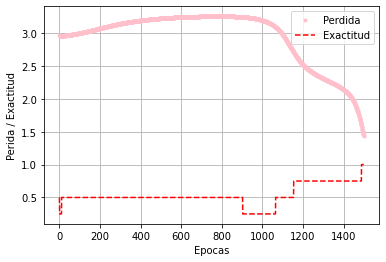

In [10]:
#reescalamos la exactitud entre 0-1 y no entre 0-100
foo = exactitudes/100
#ploteamos la perdida y la exactitud a traves de las epocas
plt.plot(np.arange(perdidas.size), perdidas, '.', label='Perdida', color = 'pink')
plt.plot(np.arange(foo.size), foo, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida / Exactitud')
plt.grid(True)
plt.show()

## Entrenemos ahora con un data set no tan de juguete

### Data set IRIS de jueguete pero no tanto

In [11]:
#hacemos uso de sklearn para importar los datos de iris
from sklearn import datasets
#generamos las clases que vamos a estudiar usamos una semilla para reproducibilidad
np.random.seed(2020)
# sean 0 = 'setosa', 1 = 'versicolor', 2 ='virginica'
print(np.random.choice(3,2, replace=False))
#elegimos las clases versicolor y virginica :)
#cargamos los datos
iris = datasets.load_iris()

[1 2]


In [12]:
#definimos nuestras etiquetas, como solo consideramos dos clases hay que recortar el dataset
y = iris.target[50:,np.newaxis]
#definimos nuestros datos de entrenamiento, igual hay que recortar el dataset
x = iris.data[50:,:]

In [13]:
np.random.seed(2020)
#juntamos los datos para poder hacer un shuffle
data = np.concatenate((x,y),axis=1)
#shufleamos los datos dos veces
np.random.shuffle(data)
np.random.shuffle(data)

In [14]:
#vamos a definir un conjunto de entrenamiento y otro de validacion, como ya estan shufleados
#solo basta con escoger los primeros 80 datos como entrenamiento y el restante como validacion
# 80% test 20% val
x_train = data[:80,:4]
y_train = data[:80,-1]
y_train = y_train[:,np.newaxis]
x_test = data[80:,:4]
y_test = data[80:,-1]

In [15]:
#amos a entrenar :D
W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacion(x_train,y_train,epochs=1500,learningRate=0.5,neuronasOcultas=3)

Epoch 0: Perdida = 7.582114051876493 Exactitud = 42.5
Epoch 1: Perdida = 0.5854372507481548 Exactitud = 47.5
Epoch 2: Perdida = 0.33990605901256926 Exactitud = 47.5
Epoch 3: Perdida = 0.2408403566360709 Exactitud = 47.5
Epoch 4: Perdida = 0.18675476567264834 Exactitud = 47.5
Epoch 5: Perdida = 0.15258084380261078 Exactitud = 47.5
Epoch 6: Perdida = 0.12900229144842365 Exactitud = 47.5
Epoch 7: Perdida = 0.11174177373893966 Exactitud = 47.5
Epoch 8: Perdida = 0.09855503746429937 Exactitud = 47.5
Epoch 9: Perdida = 0.08814975298296163 Exactitud = 47.5
Epoch 10: Perdida = 0.07972863430219153 Exactitud = 47.5
Epoch 11: Perdida = 0.07277288024961584 Exactitud = 47.5
Epoch 12: Perdida = 0.06693024079127789 Exactitud = 47.5
Epoch 13: Perdida = 0.06195309346230103 Exactitud = 47.5
Epoch 14: Perdida = 0.05766225346750955 Exactitud = 47.5
Epoch 15: Perdida = 0.05392484230687326 Exactitud = 47.5
Epoch 16: Perdida = 0.050640227696282826 Exactitud = 47.5
Epoch 17: Perdida = 0.04773079576599368 Exac

Epoch 155: Perdida = 0.005161425015601496 Exactitud = 47.5
Epoch 156: Perdida = 0.005127280236601227 Exactitud = 47.5
Epoch 157: Perdida = 0.00509357256260695 Exactitud = 47.5
Epoch 158: Perdida = 0.005060293696340649 Exactitud = 47.5
Epoch 159: Perdida = 0.005027435548878577 Exactitud = 47.5
Epoch 160: Perdida = 0.00499499023314191 Exactitud = 47.5
Epoch 161: Perdida = 0.004962950057653626 Exactitud = 47.5
Epoch 162: Perdida = 0.004931307520509324 Exactitud = 47.5
Epoch 163: Perdida = 0.004900055303584745 Exactitud = 47.5
Epoch 164: Perdida = 0.004869186266934449 Exactitud = 47.5
Epoch 165: Perdida = 0.004838693443420408 Exactitud = 47.5
Epoch 166: Perdida = 0.004808570033502902 Exactitud = 47.5
Epoch 167: Perdida = 0.004778809400250641 Exactitud = 47.5
Epoch 168: Perdida = 0.004749405064498759 Exactitud = 47.5
Epoch 169: Perdida = 0.004720350700200048 Exactitud = 47.5
Epoch 170: Perdida = 0.004691640129929489 Exactitud = 47.5
Epoch 171: Perdida = 0.00466326732054672 Exactitud = 47.5


Epoch 305: Perdida = 0.0025530707157986345 Exactitud = 47.5
Epoch 306: Perdida = 0.0025443279879990943 Exactitud = 47.5
Epoch 307: Perdida = 0.002535642938925186 Exactitud = 47.5
Epoch 308: Perdida = 0.002527015004325584 Exactitud = 47.5
Epoch 309: Perdida = 0.0025184436272673565 Exactitud = 47.5
Epoch 310: Perdida = 0.002509928258011281 Exactitud = 47.5
Epoch 311: Perdida = 0.0025014683539006733 Exactitud = 47.5
Epoch 312: Perdida = 0.0024930633792461317 Exactitud = 47.5
Epoch 313: Perdida = 0.002484712805216152 Exactitud = 47.5
Epoch 314: Perdida = 0.002476416109723754 Exactitud = 47.5
Epoch 315: Perdida = 0.002468172777323097 Exactitud = 47.5
Epoch 316: Perdida = 0.002459982299105874 Exactitud = 47.5
Epoch 317: Perdida = 0.0024518441725894947 Exactitud = 47.5
Epoch 318: Perdida = 0.002443757901628685 Exactitud = 47.5
Epoch 319: Perdida = 0.0024357229963061183 Exactitud = 47.5
Epoch 320: Perdida = 0.002427738972837022 Exactitud = 47.5
Epoch 321: Perdida = 0.002419805353477786 Exactit

Epoch 461: Perdida = 0.0016527312016616608 Exactitud = 47.5
Epoch 462: Perdida = 0.0016489484483436252 Exactitud = 47.5
Epoch 463: Perdida = 0.0016451823318403079 Exactitud = 47.5
Epoch 464: Perdida = 0.0016414327437717694 Exactitud = 47.5
Epoch 465: Perdida = 0.001637699576694979 Exactitud = 47.5
Epoch 466: Perdida = 0.0016339827240940475 Exactitud = 47.5
Epoch 467: Perdida = 0.0016302820803675672 Exactitud = 47.5
Epoch 468: Perdida = 0.0016265975408182843 Exactitud = 47.5
Epoch 469: Perdida = 0.0016229290016492152 Exactitud = 47.5
Epoch 470: Perdida = 0.0016192763599449907 Exactitud = 47.5
Epoch 471: Perdida = 0.0016156395136727427 Exactitud = 47.5
Epoch 472: Perdida = 0.0016120183616621226 Exactitud = 47.5
Epoch 473: Perdida = 0.0016084128036046282 Exactitud = 47.5
Epoch 474: Perdida = 0.0016048227400439494 Exactitud = 47.5
Epoch 475: Perdida = 0.0016012480723585324 Exactitud = 47.5
Epoch 476: Perdida = 0.0015976887027614687 Exactitud = 47.5
Epoch 477: Perdida = 0.001594144534288615

Epoch 599: Perdida = 0.001252035237244173 Exactitud = 47.5
Epoch 600: Perdida = 0.0012498169303745451 Exactitud = 47.5
Epoch 601: Perdida = 0.0012476061670772538 Exactitud = 47.5
Epoch 602: Perdida = 0.0012454029093892152 Exactitud = 47.5
Epoch 603: Perdida = 0.0012432071195989422 Exactitud = 47.5
Epoch 604: Perdida = 0.0012410187602483235 Exactitud = 47.5
Epoch 605: Perdida = 0.0012388377941272921 Exactitud = 47.5
Epoch 606: Perdida = 0.0012366641842701614 Exactitud = 47.5
Epoch 607: Perdida = 0.0012344978939622874 Exactitud = 47.5
Epoch 608: Perdida = 0.0012323388867254133 Exactitud = 47.5
Epoch 609: Perdida = 0.0012301871263263283 Exactitud = 47.5
Epoch 610: Perdida = 0.0012280425767673211 Exactitud = 47.5
Epoch 611: Perdida = 0.0012259052022890633 Exactitud = 47.5
Epoch 612: Perdida = 0.0012237749673700577 Exactitud = 47.5
Epoch 613: Perdida = 0.0012216518367168653 Exactitud = 47.5
Epoch 614: Perdida = 0.0012195357752697693 Exactitud = 47.5
Epoch 615: Perdida = 0.001217426748199442

Epoch 758: Perdida = 0.0009742826526976435 Exactitud = 47.5
Epoch 759: Perdida = 0.0009729122062133742 Exactitud = 47.5
Epoch 760: Perdida = 0.0009715454574741811 Exactitud = 47.5
Epoch 761: Perdida = 0.0009701823917283107 Exactitud = 47.5
Epoch 762: Perdida = 0.000968822994299842 Exactitud = 47.5
Epoch 763: Perdida = 0.0009674672505890212 Exactitud = 47.5
Epoch 764: Perdida = 0.0009661151460741482 Exactitud = 47.5
Epoch 765: Perdida = 0.0009647666663094665 Exactitud = 47.5
Epoch 766: Perdida = 0.0009634217969278298 Exactitud = 47.5
Epoch 767: Perdida = 0.0009620805236340379 Exactitud = 47.5
Epoch 768: Perdida = 0.0009607428322088349 Exactitud = 47.5
Epoch 769: Perdida = 0.0009594087085084659 Exactitud = 47.5
Epoch 770: Perdida = 0.000958078138463454 Exactitud = 47.5
Epoch 771: Perdida = 0.000956751108075493 Exactitud = 47.5
Epoch 772: Perdida = 0.0009554276034209985 Exactitud = 47.5
Epoch 773: Perdida = 0.0009541076106487788 Exactitud = 47.5
Epoch 774: Perdida = 0.000952791115980476 E

Epoch 899: Perdida = 0.0008118412403564853 Exactitud = 47.5
Epoch 900: Perdida = 0.0008108755593042945 Exactitud = 47.5
Epoch 901: Perdida = 0.0008099120814174189 Exactitud = 47.5
Epoch 902: Perdida = 0.0008089507992675857 Exactitud = 47.5
Epoch 903: Perdida = 0.0008079917054567217 Exactitud = 47.5
Epoch 904: Perdida = 0.0008070347926240593 Exactitud = 47.5
Epoch 905: Perdida = 0.0008060800534371433 Exactitud = 47.5
Epoch 906: Perdida = 0.0008051274805998247 Exactitud = 47.5
Epoch 907: Perdida = 0.0008041770668460431 Exactitud = 47.5
Epoch 908: Perdida = 0.0008032288049452678 Exactitud = 47.5
Epoch 909: Perdida = 0.0008022826876927259 Exactitud = 47.5
Epoch 910: Perdida = 0.0008013387079217273 Exactitud = 47.5
Epoch 911: Perdida = 0.000800396858494783 Exactitud = 47.5
Epoch 912: Perdida = 0.0007994571323058243 Exactitud = 47.5
Epoch 913: Perdida = 0.0007985195222828691 Exactitud = 47.5
Epoch 914: Perdida = 0.0007975840213784721 Exactitud = 47.5
Epoch 915: Perdida = 0.000796650622583381

Epoch 1058: Perdida = 0.0006818134524686956 Exactitud = 47.5
Epoch 1059: Perdida = 0.0006811226455960185 Exactitud = 47.5
Epoch 1060: Perdida = 0.0006804331813755156 Exactitud = 47.5
Epoch 1061: Perdida = 0.0006797450559506851 Exactitud = 47.5
Epoch 1062: Perdida = 0.0006790582654807903 Exactitud = 47.5
Epoch 1063: Perdida = 0.0006783728061379753 Exactitud = 47.5
Epoch 1064: Perdida = 0.0006776886741137019 Exactitud = 47.5
Epoch 1065: Perdida = 0.0006770058656089805 Exactitud = 47.5
Epoch 1066: Perdida = 0.0006763243768390332 Exactitud = 47.5
Epoch 1067: Perdida = 0.0006756442040377346 Exactitud = 47.5
Epoch 1068: Perdida = 0.0006749653434501728 Exactitud = 47.5
Epoch 1069: Perdida = 0.000674287791335204 Exactitud = 47.5
Epoch 1070: Perdida = 0.0006736115439674496 Exactitud = 47.5
Epoch 1071: Perdida = 0.0006729365976356317 Exactitud = 47.5
Epoch 1072: Perdida = 0.0006722629486401305 Exactitud = 47.5
Epoch 1073: Perdida = 0.00067159059329798 Exactitud = 47.5
Epoch 1074: Perdida = 0.000

Epoch 1195: Perdida = 0.0005982475059780019 Exactitud = 47.5
Epoch 1196: Perdida = 0.0005977100217954643 Exactitud = 47.5
Epoch 1197: Perdida = 0.000597173464192032 Exactitud = 47.5
Epoch 1198: Perdida = 0.0005966378308090718 Exactitud = 47.5
Epoch 1199: Perdida = 0.0005961031192930561 Exactitud = 47.5
Epoch 1200: Perdida = 0.0005955693273036708 Exactitud = 47.5
Epoch 1201: Perdida = 0.0005950364525023774 Exactitud = 47.5
Epoch 1202: Perdida = 0.0005945044925627397 Exactitud = 47.5
Epoch 1203: Perdida = 0.00059397344516465 Exactitud = 47.5
Epoch 1204: Perdida = 0.0005934433079949952 Exactitud = 47.5
Epoch 1205: Perdida = 0.0005929140787504325 Exactitud = 47.5
Epoch 1206: Perdida = 0.0005923857551332818 Exactitud = 47.5
Epoch 1207: Perdida = 0.0005918583348543008 Exactitud = 47.5
Epoch 1208: Perdida = 0.000591331815632907 Exactitud = 47.5
Epoch 1209: Perdida = 0.00059080619519407 Exactitud = 47.5
Epoch 1210: Perdida = 0.0005902814712725288 Exactitud = 47.5
Epoch 1211: Perdida = 0.000589

Epoch 1345: Perdida = 0.0005268221154521242 Exactitud = 47.5
Epoch 1346: Perdida = 0.0005264010453577601 Exactitud = 47.5
Epoch 1347: Perdida = 0.0005259806212802545 Exactitud = 47.5
Epoch 1348: Perdida = 0.0005255608417551814 Exactitud = 47.5
Epoch 1349: Perdida = 0.0005251417053231111 Exactitud = 47.5
Epoch 1350: Perdida = 0.0005247232105293884 Exactitud = 47.5
Epoch 1351: Perdida = 0.0005243053559217999 Exactitud = 47.5
Epoch 1352: Perdida = 0.0005238881400555717 Exactitud = 47.5
Epoch 1353: Perdida = 0.0005234715614879278 Exactitud = 47.5
Epoch 1354: Perdida = 0.0005230556187805335 Exactitud = 47.5
Epoch 1355: Perdida = 0.0005226403105019379 Exactitud = 47.5
Epoch 1356: Perdida = 0.0005222256352221332 Exactitud = 47.5
Epoch 1357: Perdida = 0.0005218115915151086 Exactitud = 47.5
Epoch 1358: Perdida = 0.0005213981779618479 Exactitud = 47.5
Epoch 1359: Perdida = 0.0005209853931453335 Exactitud = 47.5
Epoch 1360: Perdida = 0.0005205732356523228 Exactitud = 47.5
Epoch 1361: Perdida = 0.

Epoch 1494: Perdida = 0.00047049287347127587 Exactitud = 47.5
Epoch 1495: Perdida = 0.0004701540050954325 Exactitud = 47.5
Epoch 1496: Perdida = 0.00046981560541915844 Exactitud = 47.5
Epoch 1497: Perdida = 0.00046947767348663884 Exactitud = 47.5
Epoch 1498: Perdida = 0.00046914020834427846 Exactitud = 47.5
Epoch 1499: Perdida = 0.00046880320903737227 Exactitud = 47.5


## Jugando con los hiperparametros
Definimos lr = learning rate, e = epocas, n = neuronas ocultas por capa oculta, ex = exactitud en la ultima epoca, l = loss en la ultima epoca 

* e = 1500 , lr = 0.5, n = 7, l = 1.89z10^{-4} ex = 47.5
* e = 1500 , lr = 1, n = 7, l = 8.49x10^{-5} ex = 47.5
* e = 1500 , lr = 5, n = 7, l = 1.65x10^{-5} ex = 47.5
* e = 1500 , lr = 0.0001, n = 7, l = 1.16 ex = 47.5
* e = 1500, lr = 1, n = 1, l = 0.000302, ex = 47.5
* e = 1500, lr = 1, n = 3, l = 0.000161, ex = 47.5
* e = 1500, lr = 0.5, n = 3, l = 0.00056, ex = 47.5

Se estanca en la exactitud de 47.5 debe ser por la arquitectura y sus funciones de activacion (son las mismas) mas adelante vamos a redefinir la red.

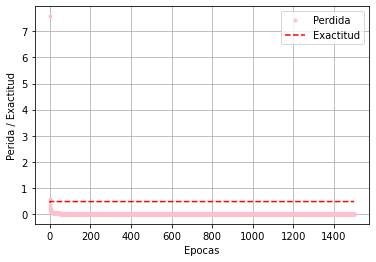

In [16]:
#ploteamos la perdida y la exactitud a traves de las epocas para los ultimos hiperparametros
plt.plot(np.arange(perdidas.size), perdidas, '.', label='Perdida', color = 'pink')
plt.plot(np.arange(exactitudes.size), exactitudes/100, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida / Exactitud')
plt.grid(True)
plt.show()

In [17]:
#validemos con nuestro conjunto de validacion
print('-----------------------------')
print('y\tprediccion')
print('-----------------------------')
for i in range(x_test.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, foo4, foo5, prediccionDespuesdeEntrenar = propagacion(x_test[i],W1,b1,W2,b2, W3, b3)
    print('{0}\t{1}'.format(y_test[i], np.round(prediccionDespuesdeEntrenar[0][0])))

-----------------------------
y	prediccion
-----------------------------
1.0	1.0
2.0	1.0
2.0	1.0
1.0	1.0
1.0	1.0
2.0	1.0
1.0	1.0
1.0	1.0
2.0	1.0
1.0	1.0
1.0	1.0
2.0	1.0
1.0	1.0
1.0	1.0
2.0	1.0
1.0	1.0
1.0	1.0
2.0	1.0
1.0	1.0
2.0	1.0


Todas las predice como clase 1 luego esto esta peor que un volado. Vamos a modificar la red a modo que tenga funcion de activacion lineal la primera capa oculta a ver que pasa.

In [18]:
#definimos la funcion de propagacion hacia adelante
def propagacionMod(x, w1, b1, w2, b2, w3, b3):
    #calculamos z2:
    z2 = (w1.T @ x[:,np.newaxis]) + b1
    #calculamos a2
    a2 = ReLU(z2)
    #calculamos z3
    z3 = (w2.T @ a2) + b2
    #calculamos a3
    a3 = tgh(z3)
    #calculamos z4
    z4 = (w3.T @ a3) + b3
    #hacemos la prediccion (obtenemos a4)
    prediccion = ReLU(z4)
    #regresamos los valores que acabamos de calcular
    return z2, a2, z3, a3, z4, prediccion

In [19]:
#definimos la funcion de activacion ReLU
def ReLU(z):
    return np.maximum(0, z)
def ReLUDerivative(z):
    if np.all(z) >= 0:
        return 1
    else:
        return 0

In [20]:
#definimos la funcion de activacion tgh
def tgh(z):
    return np.true_divide((np.exp(z)-np.exp(-z)), (np.exp(z)+np.exp(-z)))
def tghDerivative(z):
    return 1.-np.power(tgh(z),2)

In [21]:
#definimos nuestro algoritmo de retropropagacion
def retropropagacionMod(x, y, learningRate, epochs, neuronasOcultas):
    ejemplos = x.shape[0]
    entradas = x.shape[1]
    #inicializamos los pesos W y b de forma aleatoria
    W1 = np.sqrt(1.0 / entradas) * np.random.randn(entradas, neuronasOcultas)
    b1 = np.zeros((neuronasOcultas, 1))
    W2 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b2 = np.zeros((neuronasOcultas, 1))
    W3 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b3 = np.zeros((1, 1))
    #definimos el vector de perdidas, que en cada epoca se va a actualizar
    perdidas = np.zeros((epochs))
    #definimos el vector de exactitudes que en cada epoca se ca a actualizar
    exactitudes = np.zeros((epochs))
    #definimos el vector de predicciones que corresponde al numero de salidas
    predicciones = np.zeros((y.shape))
    #iteramos sobre las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos de entrenamiento
        for ejemplo in range(ejemplos):
            #calculamos los vectores resultantes de la propagacion
            z2, a2, z3, a3, z4, prediccion = propagacionMod(x[ejemplo], W1, b1, W2, b2, W3, b3)
            #algoritmo de retropropagacion:
            #3) calcula el error de la capa de salida (punto 3 del notebook de teoria)
            # gradiente de C en la direccion de a producto de haramad
            #con la derivada de la funcion de activacion evaluada en z^{L}
            gradUltimaCapa = np.multiply((prediccion - y[ejemplo]), ReLUDerivative(z4))
            #actualiza los pesos de la ultima capa usando descenso del gradiente
            W3 = W3 - learningRate * np.outer(a3, gradUltimaCapa)
            b3 = b3 - learningRate * gradUltimaCapa
            #4.1) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 3
            gradCapa3 = np.multiply((W3 @ gradUltimaCapa), tghDerivative(z3))
            #actualiza los pesos de la capa 3 usando descenso del gradiente
            W2 = W2 - learningRate * np.outer(a2, gradCapa3)
            b2 = b2 - learningRate * gradCapa3
            # 4.2) retropropaga el error al calcular d^{l} con l=L-1, L-2 ,..., 2
            #para este caso l = 2
            gradCapa2 = np.multiply((W2 @ gradCapa3), ReLUDerivative(z2))
            #actualiza los pesos de la capa 2 usando descenso del gradiente
            W1 = W1 - learningRate * np.outer(x[ejemplo], gradCapa2)
            b1 = b1 - learningRate * gradCapa2
            ##Fin de la retropropagacion
            #asignamos nuestra prediccion
            predicciones[ejemplo] = prediccion
        #calculamos la perdida para la epoca actual
        perdidas[epoch] = EntropiaBinaria(y, predicciones)
        #calculamos las exactitudes para la epoca actual
        exactitudes[epoch] = exactitud(y, np.round(predicciones))
        #imprimimos la perdida y la exactitud para la epoca actual
        print('Epoch {0}: Perdida = {1} Exactitud = {2}'.format(epoch,perdidas[epoch],exactitudes[epoch]))
    return W1, W2, W3, b1, b2, b3, perdidas, exactitudes

In [22]:
#amos a entrenar :D
np.random.seed(2055)
W1, W2, W3, b1, b2, b3, perdidas, exactitudes = retropropagacionMod(x_train,y_train,epochs=1500,learningRate=0.01,neuronasOcultas=2)

Epoch 0: Perdida = 7.481158853207506 Exactitud = 45.0
Epoch 1: Perdida = -13.916422403329136 Exactitud = 77.5
Epoch 2: Perdida = -14.517538902683304 Exactitud = 76.25
Epoch 3: Perdida = -14.38328506476977 Exactitud = 78.75
Epoch 4: Perdida = -14.115679157545657 Exactitud = 81.25
Epoch 5: Perdida = -13.778496105951417 Exactitud = 80.0
Epoch 6: Perdida = -13.406302135968184 Exactitud = 80.0
Epoch 7: Perdida = -12.988117505942089 Exactitud = 81.25
Epoch 8: Perdida = -12.503821852991681 Exactitud = 82.5
Epoch 9: Perdida = -11.955677922387068 Exactitud = 82.5
Epoch 10: Perdida = -11.339787765642802 Exactitud = 81.25
Epoch 11: Perdida = -10.672471659340195 Exactitud = 82.5
Epoch 12: Perdida = -9.974554025843531 Exactitud = 83.75
Epoch 13: Perdida = -9.268971810737389 Exactitud = 86.25
Epoch 14: Perdida = -8.588160531423817 Exactitud = 88.75
Epoch 15: Perdida = -7.964070663220119 Exactitud = 88.75
Epoch 16: Perdida = -7.408993610442671 Exactitud = 88.75
Epoch 17: Perdida = -6.91036170226917 E

Epoch 146: Perdida = -3.128572326236896 Exactitud = 96.25
Epoch 147: Perdida = -3.1285889868333085 Exactitud = 96.25
Epoch 148: Perdida = -3.1286744884262854 Exactitud = 96.25
Epoch 149: Perdida = -3.128830840305991 Exactitud = 96.25
Epoch 150: Perdida = -3.1290598737063444 Exactitud = 96.25
Epoch 151: Perdida = -3.1293630013216465 Exactitud = 96.25
Epoch 152: Perdida = -3.1297407977142004 Exactitud = 96.25
Epoch 153: Perdida = -3.130192279436493 Exactitud = 96.25
Epoch 154: Perdida = -3.1307136721339393 Exactitud = 96.25
Epoch 155: Perdida = -3.1312962872843233 Exactitud = 96.25
Epoch 156: Perdida = -3.1319228325897104 Exactitud = 96.25
Epoch 157: Perdida = -3.132560940618183 Exactitud = 96.25
Epoch 158: Perdida = -3.1331517597425105 Exactitud = 96.25
Epoch 159: Perdida = -3.1335900048634335 Exactitud = 96.25
Epoch 160: Perdida = -3.1336906486426788 Exactitud = 96.25
Epoch 161: Perdida = -3.1331422161805182 Exactitud = 96.25
Epoch 162: Perdida = -3.1320787011236444 Exactitud = 96.25
E

Epoch 300: Perdida = -2.9215594950803494 Exactitud = 95.0
Epoch 301: Perdida = -2.920314690896636 Exactitud = 95.0
Epoch 302: Perdida = -2.9190715631358173 Exactitud = 95.0
Epoch 303: Perdida = -2.917830051485298 Exactitud = 95.0
Epoch 304: Perdida = -2.916590096525077 Exactitud = 95.0
Epoch 305: Perdida = -2.9153516397097827 Exactitud = 95.0
Epoch 306: Perdida = -2.914114623350991 Exactitud = 95.0
Epoch 307: Perdida = -2.9128789905997117 Exactitud = 95.0
Epoch 308: Perdida = -2.911644685429169 Exactitud = 95.0
Epoch 309: Perdida = -2.9104116526176753 Exactitud = 95.0
Epoch 310: Perdida = -2.90917983773187 Exactitud = 95.0
Epoch 311: Perdida = -2.9079491871100736 Exactitud = 95.0
Epoch 312: Perdida = -2.9067196478459456 Exactitud = 95.0
Epoch 313: Perdida = -2.905491167772288 Exactitud = 95.0
Epoch 314: Perdida = -2.904263695445172 Exactitud = 95.0
Epoch 315: Perdida = -2.9030371801282184 Exactitud = 95.0
Epoch 316: Perdida = -2.9018115717771495 Exactitud = 95.0
Epoch 317: Perdida = -2

Epoch 452: Perdida = -2.7278487027939557 Exactitud = 96.25
Epoch 453: Perdida = -2.726418694079592 Exactitud = 96.25
Epoch 454: Perdida = -2.724985082347441 Exactitud = 96.25
Epoch 455: Perdida = -2.72354783361696 Exactitud = 96.25
Epoch 456: Perdida = -2.722106913718133 Exactitud = 96.25
Epoch 457: Perdida = -2.7206622882890756 Exactitud = 96.25
Epoch 458: Perdida = -2.719213922773792 Exactitud = 96.25
Epoch 459: Perdida = -2.717761782419975 Exactitud = 96.25
Epoch 460: Perdida = -2.716305832276813 Exactitud = 96.25
Epoch 461: Perdida = -2.714846037192866 Exactitud = 96.25
Epoch 462: Perdida = -2.713382361813995 Exactitud = 96.25
Epoch 463: Perdida = -2.711914770581382 Exactitud = 96.25
Epoch 464: Perdida = -2.710443227729565 Exactitud = 96.25
Epoch 465: Perdida = -2.7089676972844967 Exactitud = 96.25
Epoch 466: Perdida = -2.7074881430617554 Exactitud = 96.25
Epoch 467: Perdida = -2.7060045286647587 Exactitud = 96.25
Epoch 468: Perdida = -2.7045168174830443 Exactitud = 96.25
Epoch 469

Epoch 609: Perdida = -2.4338902492074177 Exactitud = 97.5
Epoch 610: Perdida = -2.4314231081171336 Exactitud = 97.5
Epoch 611: Perdida = -2.428948331513285 Exactitud = 97.5
Epoch 612: Perdida = -2.4264660082377767 Exactitud = 97.5
Epoch 613: Perdida = -2.4239762314588846 Exactitud = 97.5
Epoch 614: Perdida = -2.421479098716329 Exactitud = 97.5
Epoch 615: Perdida = -2.418974711961194 Exactitud = 97.5
Epoch 616: Perdida = -2.416463177589769 Exactitud = 97.5
Epoch 617: Perdida = -2.413944606471028 Exactitud = 97.5
Epoch 618: Perdida = -2.411419113967354 Exactitud = 97.5
Epoch 619: Perdida = -2.4088868199476674 Exactitud = 97.5
Epoch 620: Perdida = -2.406347848792566 Exactitud = 97.5
Epoch 621: Perdida = -2.4038023293910253 Exactitud = 97.5
Epoch 622: Perdida = -2.401250395127774 Exactitud = 97.5
Epoch 623: Perdida = -2.3986921838610478 Exactitud = 97.5
Epoch 624: Perdida = -2.3961278378898356 Exactitud = 97.5
Epoch 625: Perdida = -2.3935575039102277 Exactitud = 97.5
Epoch 626: Perdida = -

Epoch 765: Perdida = -2.033470323237832 Exactitud = 96.25
Epoch 766: Perdida = -2.0318606972495137 Exactitud = 96.25
Epoch 767: Perdida = -2.0297716044615544 Exactitud = 96.25
Epoch 768: Perdida = -2.027368341291164 Exactitud = 96.25
Epoch 769: Perdida = -2.0247466564034093 Exactitud = 96.25
Epoch 770: Perdida = -2.02197369826923 Exactitud = 96.25
Epoch 771: Perdida = -2.019097373989579 Exactitud = 96.25
Epoch 772: Perdida = -2.0161523192116935 Exactitud = 96.25
Epoch 773: Perdida = -2.0131638187938217 Exactitud = 96.25
Epoch 774: Perdida = -2.010150452764866 Exactitud = 96.25
Epoch 775: Perdida = -2.0071259267127517 Exactitud = 96.25
Epoch 776: Perdida = -2.0041003651926874 Exactitud = 96.25
Epoch 777: Perdida = -2.0010812417481607 Exactitud = 96.25
Epoch 778: Perdida = -1.9980740568506141 Exactitud = 96.25
Epoch 779: Perdida = -1.995082837224875 Exactitud = 96.25
Epoch 780: Perdida = -1.9921105064107025 Exactitud = 96.25
Epoch 781: Perdida = -1.9891591612368789 Exactitud = 96.25
Epoc

Epoch 923: Perdida = -1.7305983169993682 Exactitud = 96.25
Epoch 924: Perdida = -1.7294183688403097 Exactitud = 96.25
Epoch 925: Perdida = -1.72824403286905 Exactitud = 96.25
Epoch 926: Perdida = -1.7270752492718717 Exactitud = 96.25
Epoch 927: Perdida = -1.7259119588552936 Exactitud = 96.25
Epoch 928: Perdida = -1.7247541030769693 Exactitud = 96.25
Epoch 929: Perdida = -1.7236016240608758 Exactitud = 96.25
Epoch 930: Perdida = -1.7224544646026325 Exactitud = 96.25
Epoch 931: Perdida = -1.7213125681686854 Exactitud = 96.25
Epoch 932: Perdida = -1.720175878891204 Exactitud = 96.25
Epoch 933: Perdida = -1.7190443415608152 Exactitud = 96.25
Epoch 934: Perdida = -1.7179179016177348 Exactitud = 96.25
Epoch 935: Perdida = -1.7167965051421652 Exactitud = 96.25
Epoch 936: Perdida = -1.7156800988441683 Exactitud = 96.25
Epoch 937: Perdida = -1.7145686300534864 Exactitud = 96.25
Epoch 938: Perdida = -1.7134620467091648 Exactitud = 96.25
Epoch 939: Perdida = -1.712360297349547 Exactitud = 96.25
E

Epoch 1070: Perdida = -1.5955624295985185 Exactitud = 96.25
Epoch 1071: Perdida = -1.5948045311422838 Exactitud = 96.25
Epoch 1072: Perdida = -1.5940478419862554 Exactitud = 96.25
Epoch 1073: Perdida = -1.593292349489496 Exactitud = 96.25
Epoch 1074: Perdida = -1.592538041161477 Exactitud = 96.25
Epoch 1075: Perdida = -1.5917849046610595 Exactitud = 96.25
Epoch 1076: Perdida = -1.5910332949021386 Exactitud = 96.25
Epoch 1077: Perdida = -1.5902831682228897 Exactitud = 96.25
Epoch 1078: Perdida = -1.589533322182658 Exactitud = 96.25
Epoch 1079: Perdida = -1.5887840989947832 Exactitud = 96.25
Epoch 1080: Perdida = -1.5880356923195253 Exactitud = 96.25
Epoch 1081: Perdida = -1.5872882098867194 Exactitud = 96.25
Epoch 1082: Perdida = -1.586541709732251 Exactitud = 96.25
Epoch 1083: Perdida = -1.5857962211577092 Exactitud = 96.25
Epoch 1084: Perdida = -1.5850517568694158 Exactitud = 96.25
Epoch 1085: Perdida = -1.5843083200140524 Exactitud = 96.25
Epoch 1086: Perdida = -1.58356590825733 Exac

Epoch 1225: Perdida = -1.4877461278545296 Exactitud = 96.25
Epoch 1226: Perdida = -1.4871033418168058 Exactitud = 96.25
Epoch 1227: Perdida = -1.4864612697162574 Exactitud = 96.25
Epoch 1228: Perdida = -1.4858199151089284 Exactitud = 96.25
Epoch 1229: Perdida = -1.4851792816113676 Exactitud = 96.25
Epoch 1230: Perdida = -1.484539372900086 Exactitud = 96.25
Epoch 1231: Perdida = -1.4839001927109763 Exactitud = 96.25
Epoch 1232: Perdida = -1.4832617448386154 Exactitud = 96.25
Epoch 1233: Perdida = -1.4826240331357639 Exactitud = 96.25
Epoch 1234: Perdida = -1.4819870615125013 Exactitud = 96.25
Epoch 1235: Perdida = -1.4813508339358934 Exactitud = 96.25
Epoch 1236: Perdida = -1.4807153544289966 Exactitud = 96.25
Epoch 1237: Perdida = -1.4800806270705005 Exactitud = 96.25
Epoch 1238: Perdida = -1.4794466559938209 Exactitud = 96.25
Epoch 1239: Perdida = -1.4788134453865074 Exactitud = 96.25
Epoch 1240: Perdida = -1.4781809994895563 Exactitud = 96.25
Epoch 1241: Perdida = -1.477549322596601 

Epoch 1371: Perdida = -1.4039310481382787 Exactitud = 96.25
Epoch 1372: Perdida = -1.4034449880826485 Exactitud = 96.25
Epoch 1373: Perdida = -1.402960333226407 Exactitud = 96.25
Epoch 1374: Perdida = -1.4024770857021427 Exactitud = 96.25
Epoch 1375: Perdida = -1.401995247562638 Exactitud = 96.25
Epoch 1376: Perdida = -1.401514820780384 Exactitud = 96.25
Epoch 1377: Perdida = -1.4010358072472753 Exactitud = 96.25
Epoch 1378: Perdida = -1.4005582087741475 Exactitud = 96.25
Epoch 1379: Perdida = -1.4000820270904226 Exactitud = 96.25
Epoch 1380: Perdida = -1.3996072638437986 Exactitud = 96.25
Epoch 1381: Perdida = -1.399133920599926 Exactitud = 96.25
Epoch 1382: Perdida = -1.3986619988421014 Exactitud = 96.25
Epoch 1383: Perdida = -1.3981914999709537 Exactitud = 96.25
Epoch 1384: Perdida = -1.397722425304232 Exactitud = 96.25
Epoch 1385: Perdida = -1.397254776076509 Exactitud = 96.25
Epoch 1386: Perdida = -1.3967885534390823 Exactitud = 96.25
Epoch 1387: Perdida = -1.3963237584594925 Exac

## Jugando con los hiperparametros
Definimos lr = learning rate, e = epocas, n = neuronas ocultas por capa oculta, ex = exactitud en la ultima epoca, l = loss en la ultima epoca 

ReLU -> Tgh -> ReLU
* e = 1500 , lr = 0.01, n = 2, l = -1.35 ex = 96.25
* e = 1500 , lr = 0.1, n = 2, l = -16.1 ex = 45
* e = 1500 , lr = 0.05, n = 2, l = -16.22 ex = 46.25
* e = 1500 , lr = 0.05, n = 6, l = -16.04 ex = 46.25
* e = 1500 , lr = 0.2, n = 6, l = -10 ex = 37.5
* e = 1500, lr = 0.2, n = 1, l = -15.97, ex = 47.5

Parece que un learning rate bajo y 2 neuronas son los parametros optimos

ReLU -> Tgh -> sigmoide
* e = 1500, lr = 0.2, n = 1, l = -16.37, ex = 46.25
* e = 1500, lr = 0.01, n = 1, l = -16.06, ex = 52.5
* e = 1500, lr = 0.01, n = 2, l = -16.06, ex = 52.5
* e = 1500, lr = 0.1, n = 2, l = -16.31, ex = 46.25
* e = 1500, lr = 0.1, n = 10, l = -16.53, ex = 48.75
* e = 1500, lr = 0.0001, n = 20, l = -16.31, ex = 52.5

Aqui no hay resultados concluyentes

ReLU -> ReLU -> ReLU
* e = 1500, lr = 0.001, n = 1, l = -3.51, ex = 98.75
* e = 1500, lr = 0.01, n = 1, l = -16.1, ex = 52.5
* e = 1500, lr = 0.001, n = 2, l = -3.07, ex = 97.5
* e = 1500, lr = 0.001, n = 6, l = -3.51, ex = 98.75

Con lr mayores a 0.01 la perdida se vuelve nan por lo que debemos trabajar con lr pequenos. Aumentar las capas ocultas hace que converja mas rapido

Cambiar las funciones de activacion y sus derivadas se hace manualmente. Sin embargo, la funcion de retropropagacion puede agregar la funcionalidad de cambiar automaticamente las funciones de activacion y sus derivadas segun los parametros que se le pasen pero eso no lo hago por salud mental y no es el fin de la tarea.

Dejamos la primera configuracion con sus parametros optimos ReLU -> Tgh -> ReLU

*Nota el menso de Pedro no puso la semilla aleatoria por lo que los resultados podrian variar ligeramente

In [23]:
#validemos con nuestro conjunto de validacion
print('-----------------------------')
print('y\tprediccion')
print('-----------------------------')
#creamos una lista para guardar las predicciones de test
listaPredicciones = []
for i in range(x_test.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, foo4, foo5, prediccionDespuesdeEntrenar = propagacionMod(x_test[i],W1,b1,W2,b2, W3, b3)
    print('{0}\t{1}'.format(y_test[i], np.round(prediccionDespuesdeEntrenar[0][0])))
    #guaramos en la lista las predicciones
    listaPredicciones.append(np.round(prediccionDespuesdeEntrenar[0][0]))

-----------------------------
y	prediccion
-----------------------------
1.0	1.0
2.0	1.0
2.0	2.0
1.0	1.0
1.0	1.0
2.0	2.0
1.0	1.0
1.0	1.0
2.0	2.0
1.0	1.0
1.0	1.0
2.0	2.0
1.0	1.0
1.0	1.0
2.0	2.0
1.0	1.0
1.0	2.0
2.0	2.0
1.0	1.0
2.0	2.0


In [24]:
print('La exactitud para los datos de test es de {0}'.format((y_test==listaPredicciones).mean()*100))

La exactitud para los datos de test es de 90.0


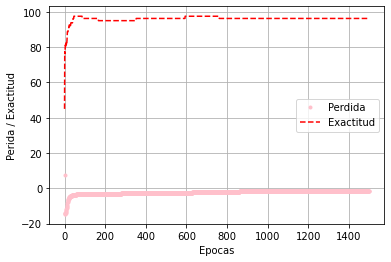

In [25]:
#ploteamos la perdida y la exactitud a traves de las epocas para los hiperparametros optimos ReLU -> Tgh -> ReLU
plt.plot(np.arange(perdidas.size), perdidas, '.', label='Perdida', color = 'pink')
plt.plot(np.arange(exactitudes.size), exactitudes, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida / Exactitud')
plt.grid(True)
#plt.xlim(0, 1500)
#plt.ylim(-8, 3)
plt.show()